# <font color='blue'> **Clasificación**
<font color='blue'> Tras haber analizado detenidamente la estructura de los datos en la fase de Visualización, vamos a diseñar una estrategia de Preprocesamiento para preparar los datos con los que vamos a entrenar los modelos. La idea es transformar los datos a una estructura que el algoritmo de clasificación acepte, al mismo que tiempo que maximice su capacidad de generalización. Tras ello, analizaremos los resultados y estudiaremos el rendimiento de los distintos modelos entrenados.

 ##  **1. Importar dataset**
 En primer lugar vamos a importar los tres archivos donde se encuentran nuestros datos. Cada uno posee una estructura distintas, por lo que tendremos que uniformizarlos.
A continuación combinaremos los tres datasets para formar nuestro corpus de correos spam.

In [3]:
#INSTALAR PAQUETES
#!pip install pandas
#!pip install wordcloud
#!pip install imbalanced-learn
#!pip install seaborn
#!pip install nltk

#IMPORTAR PAQUETES
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS #Lista predeterminada de palabras vacías en inglés
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS #Lista predeterminada de palabras vacías en inglés
import string
import re  #Biblioteca para utilizar expresiones regulares
import nltk #Biblioteca para técnicas de PLN
from nltk.tokenize import word_tokenize
nltk.download('punkt') #Datos para tokenizar
from imblearn.over_sampling import RandomOverSampler
from nltk import bigrams, trigrams
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from urlextract import URLExtract

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\monic\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\monic\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Leer los datos desde Google Drive**

In [5]:
'''
#Para acceder a nuestros ficheros de Google Drive
from google.colab import drive
drive.mount('/content/drive')
'''

"\n#Para acceder a nuestros ficheros de Google Drive\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [6]:
'''
dataFolder = 'drive/MyDrive/Colab Notebooks/datos_tfg/'
data1 = pd.read_csv(dataFolder + "/enronSpamSubset.csv")
data2 = pd.read_csv(dataFolder + "/lingSpam.csv")
data3 = pd.read_csv(dataFolder + "/completeSpamAssassin.csv")
'''

'\ndataFolder = \'drive/MyDrive/Colab Notebooks/datos_tfg/\'\ndata1 = pd.read_csv(dataFolder + "/enronSpamSubset.csv")\ndata2 = pd.read_csv(dataFolder + "/lingSpam.csv")\ndata3 = pd.read_csv(dataFolder + "/completeSpamAssassin.csv")\n'

**Leer los datos desde el PC**

In [8]:
#Para leer desde el pc
data1=pd.read_csv("../datos/enronSpamSubset.csv")
data2=pd.read_csv("../datos/lingSpam.csv")
data3=pd.read_csv("../datos/completeSpamAssassin.csv")

## **2. Preprocesamiento**

Tras el análisis descriptivo y exploratorio del problema realizado en Visualizacion.ipynb, hemos comprendido mejor cómo se comportan nuestros datos. Ahora procedemos a la transformación de estos a una estructura que permita a los algoritmos de clasificación llegar a su máxima eficiencia.
Dicho preprocesamiento se divide en dos:
- **Limpieza y representación de los datos:** ya explicado detenidamente durante la fase de visualización
- **Transformación de los datos:** realizaremos una selección de características, un balanceo de clases y la vectorización de los términos en un formato aceptable para los algoritmos de clasificación que vamos a aplicar.

In [11]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  10000 non-null  int64 
 1   Unnamed: 0    10000 non-null  int64 
 2   Body          10000 non-null  object
 3   Label         10000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 312.6+ KB


In [12]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2605 entries, 0 to 2604
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2605 non-null   int64 
 1   Body        2605 non-null   object
 2   Label       2605 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.2+ KB


In [13]:
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6046 entries, 0 to 6045
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6046 non-null   int64 
 1   Body        6045 non-null   object
 2   Label       6046 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.8+ KB


Como los datos provienen de tres fuentes distintas, tenemos que uniformizar su estructura para que tengan únicamente 2 columnas: el cuerpo del mensaje (Body) y su etiqueta (Label).

In [15]:
#Quitamos para cada dataset las columnas irrelevantes
data1.drop(["Unnamed: 0","Unnamed: 0.1"],inplace=True,axis=1)
data2.drop("Unnamed: 0",inplace=True,axis=1)
data3.drop("Unnamed: 0",inplace=True,axis=1)

### **Limpieza y representación de los datos**
Realizamos la misma limpieza de datos que en Visualización.ipynb

In [17]:
#Función que toma un texto y sustituye las contracciones por la expresión completa
def quitar_contracciones(texto):
    #Definimos un diccionario de contracciones y sus expansiones completas
    contracciones = {
        r"ain\'t": "am not",
        r"aren\'t": "are not",
        r"can\'t": "cannot",
        r"can\'t\'ve": "cannot have",
        r"\'cause": "because",
        r"could\'ve": "could have",
        r"couldn\'t": "could not",
        r"couldn\'t\'ve": "could not have",
        r"didn\'t": "did not",
        r"doesn\'t": "does not",
        r"don\'t": "do not",
        r"hadn\'t": "had not",
        r"hadn\'t\'ve": "had not have",
        r"hasn\'t": "has not",
        r"haven\'t": "have not",
        r"he\'d": "he had",
        r"he\'d\'ve": "he would have",
        r"he\'ll": "he will",
        r"he\'ll\'ve": "he will have",
        r"he\'s": "he is",
        r"how\'d": "how did",
        r"how\'d\'y": "how do you",
        r"how\'ll": "how will",
        r"how\'s": "how is",
        r"i\'d": "i had",
        r"i\'d\'ve": "i would have",
        r"i\'ll": "i will",
        r"i\'ll\'ve": "i will have",
        r"i\'m": "i am",
        r"i\'ve": "i have",
        r"isn\'t": "is not",
        r"it\'d": "it had",
        r"it\'d\'ve": "it would have",
        r"it\'ll": "it will",
        r"it\'ll\'ve": "it will have",
        r"it\'s": "it is",
        r"let\'s": "let us",
        r"ma\'am": "madam",
        r"mayn\'t": "may not",
        r"might\'ve": "might have",
        r"mightn\'t": "might not",
        r"mightn\'t\'ve": "might not have",
        r"must\'ve": "must have",
        r"mustn\'t": "must not",
        r"mustn\'t\'ve": "must not have",
        r"needn\'t": "need not",
        r"needn\'t\'ve": "need not have",
        r"o\'clock": "of the clock",
        r"oughtn\'t": "ought not",
        r"oughtn\'t\'ve": "ought not have",
        r"shan\'t": "shall not",
        r"sha\'n\'t": "shall not",
        r"shan\'t\'ve": "shall not have",
        r"she\'d": "she had",
        r"she\'d\'ve": "she would have",
        r"she\'ll": "she will",
        r"she\'ll\'ve": "she will have",
        r"she\'s": "she is",
        r"should\'ve": "should have",
        r"shouldn\'t": "should not",
        r"shouldn\'t\'ve": "should not have",
        r"so\'ve": "so have",
        r"so\'s": "so as",
        r"that\'d": "that would",
        r"that\'d\'ve": "that would have",
        r"that\'s": "that is",
        r"there\'d": "there had",
        r"there\'d\'ve": "there would have",
        r"there\'s": "there is",
        r"they\'d": "they had",
        r"they\'d\'ve": "they would have",
        r"they\'ll": "they will",
        r"they\'ll\'ve": "they will have",
        r"they\'re": "they are",
        r"they\'ve": "they have",
        r"to\'ve": "to have",
        r"wasn\'t": "was not",
        r"we\'d": "we had",
        r"we\'d\'ve": "we would have",
        r"we\'ll": "we will",
        r"we\'ll\'ve": "we will have",
        r"we\'re": "we are",
        r"we\'ve": "we have",
        r"weren\'t": "were not",
        r"what\'ll": "what will",
        r"what\'ll\'ve": "what will have",
        r"what\'re": "what are",
        r"what\'s": "what is",
        r"what\'ve": "what have",
        r"when\'s": "when is",
        r"when\'ve": "when have",
        r"where\'d": "where did",
        r"where\'s": "where is",
        r"where\'ve": "where have",
        r"who\'ll": "who will",
        r"who\'ll\'ve": "who will have",
        r"who\'s": "who is",
        r"who\'ve": "who have",
        r"why\'s": "why is",
        r"why\'ve": "why have",
        r"will\'ve": "will have",
        r"won\'t": "will not",
        r"won\'t\'ve": "will not have",
        r"would\'ve": "would have",
        r"wouldn\'t": "would not",
        r"wouldn\'t\'ve": "would not have",
        r"y\'all": "you all",
        r"y\'all\'d": "you all would",
        r"y\'all\'d\'ve": "you all would have",
        r"y\'all\'re": "you all are",
        r"y\'all\'ve": "you all have",
        r"you\'d": "you had",
        r"you\'d\'ve": "you would have",
        r"you\'ll": "you will",
        r"you\'ll\'ve": "you will have",
        r"you\'re": "you are",
        r"you\'ve": "you have"
    }

    #Sustituimos las contracciones en el texto
    for contraccion, expansion in contracciones.items():
        texto = re.sub(contraccion, expansion, texto)

    return texto

In [18]:
def limpieza(dataset):
    data = dataset.copy() #Creamos una copia explícita para evitar errores

    #Buscamos y eliminamos las instancias duplicadas
    data.drop_duplicates(inplace=True)

    #Reemplazamos los espacios en blanco con NaN.
    #Para ello, usamos una expresión regular para reemplazar cualquier cadena que contenga únicamente espacios en blanco
    data['Body'] = data['Body'].replace(r'^\s*$', pd.NA, regex=True)

    # Eliminamos los correos con valores nulos
    data.dropna(subset=['Body'], inplace=True)

    # Quitamos mayúsculas
    data['Body'] = data['Body'].str.lower()

    # Reemplazamos las URLs por el token 'URL'
    #url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    #data['Body'] = data['Body'].apply(lambda x: re.sub(url_pattern, 'URL', x))

    #OTRA OPCIÓN: URLExtract
    extractor = URLExtract()
    data['Body'] = data['Body'].apply(lambda x: ' '.join(['URL' if extractor.has_urls(word) else word for word in x.split()]))
    

    #Antes de eliminar los signos de puntuación, eliminamos las contracciones del inglés para que no queden letras sueltas
    data['Body'] = data['Body'].apply(quitar_contracciones)

    # Eliminamos signos de puntuación
    data['Body'] = data['Body'].str.replace(f'[{string.punctuation}]', ' ', regex=True)

    # Eliminamos todos los elementos que no sean caracteres alfabéticos
    #pattern = "[^a-zA-Z0-9]"
    pattern = "[^a-zA-Z ]"  # Espacio incluido para no eliminar los espacios entre palabras
    data['Body'] = data['Body'].apply(lambda x: re.sub(pattern, ' ', x))

    # Creamos una lista personalizada de palabras vacías o stop words
    stop_words_list = list(ENGLISH_STOP_WORDS)
    stop_words_list += ["subject"]

    # Eliminamos las stop words
    data['Body'] = data['Body'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words_list]))

    # Eliminamos términos con longitud menor que 2
    data['Body'] = data['Body'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 1]))

    return data


In [19]:
data1_clean=limpieza(data1)
data2_clean=limpieza(data2)
data3_clean=limpieza(data3)

A continuación concatenamos los tres Dataframes.

In [21]:
#Concatenar los tres dataframes
data_clean = pd.concat([data1_clean, data2_clean, data3_clean], ignore_index=True)

# Verificar la información del DataFrame
print(data_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17570 entries, 0 to 17569
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Body    17570 non-null  object
 1   Label   17570 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 274.7+ KB
None


### **Selección de características**

Debido a que cuando vectoricemos el conjunto de datos, las características serán las palabras y los valores de estas la frecuencia en el correo, queremos quitar **características irrelevantes** eliminado las palabras cuya frecuencia total sea casi nula, pues no aportan gran cosa.

Realizamos esta selección antes que nada, pues al aplicar el balanceo de clases tendremos muchas más palabras y esto puede afectar al rendimiento, y también puede distorsionar la frecuencia real de los términos.

In [23]:
def seleccion_caracteristicas(data):
    #Contar frecuencia de cada palabra en todo el dataset
    all_words = ' '.join(data['Body']).split()
    word_freq = Counter(all_words)
    
    # Filtrar palabras con frecuencia menor igual que 5
    data['Body'] = data['Body'].apply(lambda x: ' '.join([word for word in x.split() if word_freq[word] > 5]))

    #Mostramos las palabras después del filtrado
    all_words = ' '.join(data['Body']).split()
    word_freq = Counter(all_words)
    # Mostrar los 50 primeros términos y sus frecuencias
    top_words = list(word_freq.items())[:50]
    print(top_words)
    
    return data

In [24]:
data=seleccion_caracteristicas(data_clean)

[('stock', 2620), ('promo', 49), ('mover', 11), ('cwtd', 45), ('urgent', 275), ('investor', 550), ('trading', 2324), ('alert', 279), ('weekly', 516), ('pick', 491), ('china', 724), ('world', 4579), ('trade', 1352), ('corp', 2474), ('ticker', 38), ('breaking', 221), ('news', 2839), ('enters', 70), ('agreement', 1433), ('acquire', 371), ('majority', 401), ('stake', 171), ('ceo', 617), ('clubs', 38), ('limited', 2043), ('guangzhou', 9), ('market', 3337), ('wire', 203), ('apr', 152), ('otc', 237), ('bb', 170), ('ob', 135), ('announced', 698), ('today', 3400), ('entered', 358), ('acquired', 260), ('hong', 354), ('kong', 329), ('corporation', 803), ('authorized', 132), ('chapter', 782), ('operate', 248), ('trademarks', 126), ('greater', 456), ('region', 454), ('including', 3547), ('prc', 240), ('taiwan', 241), ('symbol', 319), ('price', 4417)]


In [25]:
data

,Body,Label
0,stock promo mover cwtd urgent investor trading...,1
1,listed major search engines submitting website...,1
2,important information thu jun important inform...,1
3,utf life utf individual utf internal utf years...,1
4,bidstogo places things hello privacy policy pe...,1
...,...,...
17565,isilo tm palm os pocket pc windows enters beta...,0
17566,effector vol november ren eff orga publication...,0
17567,extended free seat sale thursday st november d...,0
17568,insignificant matters heavily hugh mt time imh...,0


### **Balanceo de clases**

En la fase de visualización vimos que las clases están bastante desbalanceadas. Para resolver este problema, vamos a aplicar **sobremuestreo**. Para ello, usaremos la función `RandomOverSampler` de la biblioteca `imbalanced-learn`. `RandomOverSampler` va replicando aleatoriamente las instancias de la clase minoritaria hasta alcanzar un equilibrio deseado.

In [27]:
#Función para visualizar la distribución de las clases (para ver si hay desbalanceo)
def distribucion(data, title):
    #Calculo la cantidad de correos electrónicos en cada clase
    class_distribution = data['Label'].value_counts()
    class_distribution = class_distribution.sort_index() #Simplemente para que la clase 0 aparezca primero

    # Visualizar la distribución de las clases
    plt.figure(figsize=(8, 6))
    class_distribution.plot(kind='bar', color= ['#45D2EB', '#FF5733'])
    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Cantidad de Correos Electrónicos')
    plt.xticks(rotation=0)
    plt.show()

    print(class_distribution)

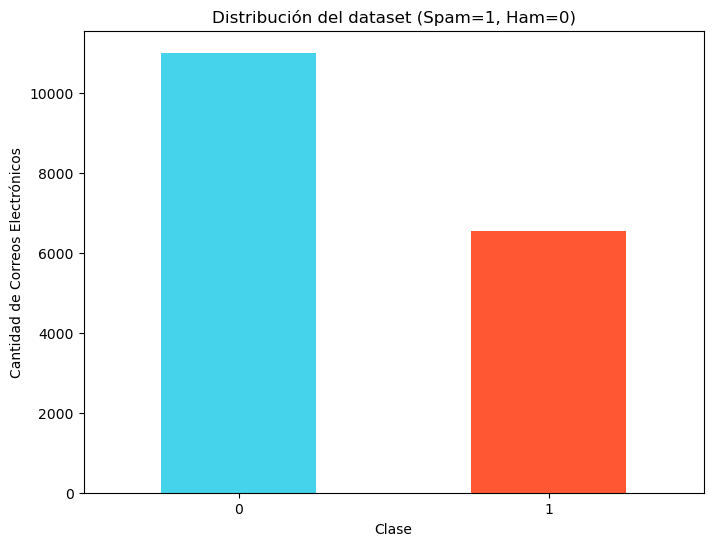

Label
0    11010
1     6560
Name: count, dtype: int64


In [28]:
distribucion(data, "Distribución del dataset (Spam=1, Ham=0)")

Observamos que hay casi el doble de instancias Ham que de Spam. Procedemos a aplicar sobremuestreo de la clase minoritaria.

In [30]:
def sobremuestreo(data):
    # Separamos las características y las etiquetas
    X = data.drop('Label', axis=1)  # características
    y = data['Label']  # etiquetas
    
    # Aplico el sobremuestreo
    oversample = RandomOverSampler(sampling_strategy='minority')
    X_resampled, y_resampled = oversample.fit_resample(X, y)
    
    # Concatenamos las características y las etiquetas en un nuevo DataFrame
    data_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['Label'])], axis=1)
    
    # Ahora 'data_resampled' contiene el conjunto de datos con clases balanceadas
    return data_resampled


In [31]:
data_resampled=sobremuestreo(data)

In [32]:
data_resampled

,Body,Label
0,stock promo mover cwtd urgent investor trading...,1
1,listed major search engines submitting website...,1
2,important information thu jun important inform...,1
3,utf life utf individual utf internal utf years...,1
4,bidstogo places things hello privacy policy pe...,1
...,...,...
22015,new game hidden gem new opportunity investor a...,1
22016,make dollars day home pop working hours day de...,1
22017,dear sir madam petr managing iraq today news s...,1
22018,anxiety codeine tylenol help buy codeine tylen...,1


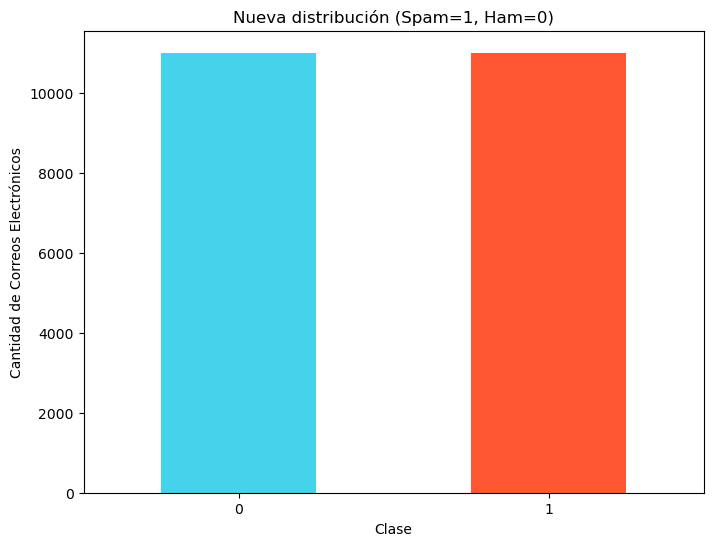

Label
0    11010
1    11010
Name: count, dtype: int64


In [33]:
distribucion(data_resampled, "Nueva distribución (Spam=1, Ham=0)")

### **División del conjunto de datos**

In [35]:
data=data_resampled

In [36]:
#Función para dividir el conjunto de datos en entrenamiento y prueba
def division_datos(data):
    X= data["Body"] #Atributos (sólo hay uno)
    y= data["Label"] #Etiquetas
    X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42) #Dividimos en conjunto de entrenamiento y de prueba (20% prueba)

    return X_train, X_test, y_train, y_test

In [37]:
X_train, X_test, y_train, y_test= division_datos(data)

### **Vectorización**

In [39]:
#Función para vectorizar el conjunto de datos
def vectorizacion(X_train, X_test, tipo):
    if tipo=="binary":
        vectorizer=CountVectorizer(binary=True) #Vectorización binaria: las características toman el valor 1 si el término aparece, y 0 si no aparece
    elif tipo=="count":
        vectorizer=CountVectorizer() #Vectorización por conteo: las características toman el valor del número de apariciones de cada término
    elif tipo=="tfidf":
        vectorizer=TfidfVectorizer()
    else:
        print("Error. Indica el tipo de vectorización: 'count', 'binary'  o 'tfidf'.")
        return
    X_train=vectorizer.fit_transform(X_train)
    X_test=vectorizer.transform(X_test)
    #print(vectorizer.vocabulary_)

    return X_train, X_test, vectorizer

In [40]:
#Obtenemos los conjuntos de entrenamiento y test aplicándoles los vectorizadores

#Vectorizador para Naive Bayes Bernoulli
X_train_0, X_test_0, vectorizer_0= vectorizacion(X_train, X_test, "binary") 

#Vectorizador para el resto de modelos
X_train_1, X_test_1, vectorizer_1= vectorizacion(X_train, X_test, "count") 
X_train_2, X_test_2, vectorizer_2= vectorizacion(X_train, X_test, "tfidf")

## **3. Búsqueda del mejor modelo**

En esta sección realizamos una **búsqueda de hiperparámetros** con el fin de encontrar los valores más óptimos para cada modelo. El problema principal que hemos encontrado es que, por ejemplo, para SVC, al tener tantas posibles combinaciones, y ser un algoritmo más complejo, tarda entre 2 y 10 minutos por iteración.

- Para SVC usamos `RandomizedSearchCV` ya que tenemos muchos hiperparámetros y va a tardar una eternidad
- Para NBM usamos `GridSearchCV`

**Nota**: Fijamos una semilla `random_state=42` para siempre obtener los mismos resultados y no depender de la aleatoriedad.

In [42]:
def busqueda_hiperparametros(param_grid, clasificador, X_train, y_train, name):
    #Definimos el método de validación cruzada
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv0 = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    
    #Definición de la herramienta de búsqueda: GridSearchCV o RandomizedSearchCV
    if clasificador==SVC: #Lo hacemos random y con solo 3 iteraciones pues tarda mucho
        grid = RandomizedSearchCV(SVC(random_state=42), param_grid, n_iter=3, cv=cv0, scoring='accuracy', random_state=42, verbose=2)
        #Ponemos random_state=42 para que siempre se ejecuten las mismas combinaciones...
    else:
        grid = GridSearchCV(clasificador(), param_grid, cv=cv, scoring='accuracy', verbose=2)
    
    #Ejecutamos la búsqueda de hiperparámetros
    grid.fit(X_train, y_train)
    print(f"{name} best parameters: {grid.best_params_}")
    print(f"{name} best CV accuracy: {grid.best_score_}\n\n")

    return grid.best_params_

### **Naive Bayes**

#### Naive Bayes Multinomial

In [45]:
param_grid_NB = {
        'alpha': [1.0, 0.5, 0.2, 0.1, 0.01, 0.001, 0]  # Diferentes valores de alpha para probar
    }
best_params_NB_1=busqueda_hiperparametros(param_grid_NB, MultinomialNB, X_train_1, y_train, "NB Multinomial (Count)")
best_params_NB_2=busqueda_hiperparametros(param_grid_NB, MultinomialNB, X_train_2, y_train, "NB Multinomial (TF-IDF)")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ........................................

#### Naive Bayes de Bernoulli

In [47]:
best_params_NB_0=busqueda_hiperparametros(param_grid_NB, BernoulliNB, X_train_0, y_train, "NB Bernoulli (Count binario)")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ........................................

### **Support Vector Machines**

#### SVC
Debido al alto número de combinaciones de hiperparámetros de SVC, vamos a realizar la búsqueda de los mejores hiperparámetros con `RandomizedSearchCV`, el cual prueba `n_iter` combinaciones distintas y se queda con la mejor. 

In [50]:
param_grid_SVC = {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto', 0.1, 1, 10],
        'kernel': ['rbf', 'linear', 'poly']
    }
best_params_SVC_1=busqueda_hiperparametros(param_grid_SVC, SVC, X_train_1, y_train, "SVC (Count)")
best_params_SVC_2=busqueda_hiperparametros(param_grid_SVC, SVC, X_train_2, y_train, "SVC (TF-IDF)")

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time= 2.7min
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time= 3.2min
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  11.6s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  11.7s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=  30.8s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=  32.9s
SVC (Count) best parameters: {'kernel': 'linear', 'gamma': 1, 'C': 1}
SVC (Count) best CV accuracy: 0.9650317892824705


Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=  55.8s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=  57.5s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=  25.6s
[CV] END .......................

**Observación**: A pesar de limitar el número de iteraciones de `RandomizedSearchCV` a `n_iter=5`, hemos visto que la ejecución tarda demasiado, debido al gran número de instancias. Por lo que hemos decidido probar también con LinearSVC y SGDClassifier, tal y como se recomienda en la documentación (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC). Ahora sí usamos `GridSearchCV` para buscar la mejor combinación de hiperparámetros.

#### LinearSVC

In [53]:
param_grid_LinearSVC = {
        'C': [0.1, 1, 10],
        'max_iter': [1000, 5000, 10000]
    }
best_params_LinearSVC_1=busqueda_hiperparametros(param_grid_LinearSVC, LinearSVC, X_train_1, y_train, "LinearSVC (Count)")
best_params_LinearSVC_2=busqueda_hiperparametros(param_grid_LinearSVC, LinearSVC, X_train_2, y_train, "LinearSVC (TF-IDF)")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ...............................C=0.1, max_iter=1000; total time=   0.4s
[CV] END ...............................C=0.1, max_iter=1000; total time=   0.5s
[CV] END ...............................C=0.1, max_iter=1000; total time=   0.4s
[CV] END ...............................C=0.1, max_iter=1000; total time=   0.4s
[CV] END ...............................C=0.1, max_iter=1000; total time=   0.5s
[CV] END ...............................C=0.1, max_iter=5000; total time=   2.2s
[CV] END ...............................C=0.1, max_iter=5000; total time=   2.3s
[CV] END ...............................C=0.1, max_iter=5000; total time=   1.9s
[CV] END ...............................C=0.1, max_iter=5000; total time=   2.2s
[CV] END ...............................C=0.1, max_iter=5000; total time=   1.9s
[CV] END ..............................C=0.1, max_iter=10000; total time=   1.9s
[CV] END ..............................C=0.1, max

#### SGDClassifier

In [55]:
param_grid_SGD = {
        'alpha': [0.0001, 0.001, 0.01],
        'loss': ['hinge', 'log', 'modified_huber'],
        'penalty': ['l2', 'l1', 'elasticnet']
    }
best_params_SGDClassifier_1=busqueda_hiperparametros(param_grid_SGD, SGDClassifier, X_train_1, y_train, "SGDClassifier (Count)")
best_params_SGDClassifier_2=busqueda_hiperparametros(param_grid_SGD, SGDClassifier, X_train_2, y_train, "SGDClassifier (TF-IDF)")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l2; total time=   0.0s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l2; total time=   0.1s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l2; total time=   0.0s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l2; total time=   0.0s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l2; total time=   0.0s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l1; total time=   5.0s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l1; total time=   6.4s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l1; total time=   5.5s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l1; total time=   3.6s
[CV] END ...............alpha=0.0001, loss=hinge, penalty=l1; total time=   4.0s
[CV] END .......alpha=0.0001, loss=hinge, penalty=elasticnet; total time=   0.5s
[CV] END .......alpha=0.0001, loss=hinge, penal

#### **Resultados**
Observamos que las siguientes configuraciones de hiperparámetros son las que conducen a los mejores modelos:

In [57]:
print(f"""Hiperparámetros del mejor modelo para Naive Bayes Multinomial: 
    CountVectorizer: {best_params_NB_1}
    TfidfVectorizer: {best_params_NB_2}
    """)

print(f"""Hiperparámetros del mejor modelo para Naive Bayes de Bernoulli: 
    CountVectorizer (binary=True): {best_params_NB_0}
    """)

print(f"""Hiperparámetros del mejor modelo para SVC: 
    CountVectorizer: {best_params_SVC_1}
    TfidfVectorizer: {best_params_SVC_2}
    """)

print(f"""Hiperparámetros del mejor modelo para LinearSVC: 
    CountVectorizer: {best_params_LinearSVC_1}
    TfidfVectorizer: {best_params_LinearSVC_2}
    """)

print(f"""Hiperparámetros del mejor modelo para SGDClassifier: 
    CountVectorizer: {best_params_SGDClassifier_1}
    TfidfVectorizer: {best_params_SGDClassifier_2}
    """)

Hiperparámetros del mejor modelo para Naive Bayes Multinomial: 
    CountVectorizer: {'alpha': 0.01}
    TfidfVectorizer: {'alpha': 0.1}
    
Hiperparámetros del mejor modelo para Naive Bayes de Bernoulli: 
    CountVectorizer (binary=True): {'alpha': 0.001}
    
Hiperparámetros del mejor modelo para SVC: 
    CountVectorizer: {'kernel': 'linear', 'gamma': 1, 'C': 1}
    TfidfVectorizer: {'kernel': 'rbf', 'gamma': 1, 'C': 10}
    
Hiperparámetros del mejor modelo para LinearSVC: 
    CountVectorizer: {'C': 0.1, 'max_iter': 1000}
    TfidfVectorizer: {'C': 1, 'max_iter': 1000}
    
Hiperparámetros del mejor modelo para SGDClassifier: 
    CountVectorizer: {'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l2'}
    TfidfVectorizer: {'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'l2'}
    


## **4. Entrenamiento y validación del mejor modelo**

El entrenamiento de modelos de Aprendizaje Automático y la estimación del error fuera de la muestra son cruciales para entender cómo los modelos generalizarán a instancias o datos nuevos, que no fueron considerados durante el entrenamiento. Este apartado aborda cómo se entrenaron los modelos, cómo se estimó el error fuera de la muestra y qué conclusiones podemos extraer de los resultados.


**Entrenamiento de los modelos**

Los modelos seleccionados fueron entrenados utilizando el conjunto de entrenamiento (`X_train`: espacio de características, `y_train`: etiquetas). Para cada modelo, se utilizaron los mejores hiperparámetros calculados mediante GridSearchCV, asegurando que cada modelo estuviera optimizado. El entrenamiento del modelo consiste en primer lugar en definir el objeto de validación cruzada, y pasarle el modelo declarado. Tras ello, con `model.fit` se entrena el modelo con el conjunto de entrenamiento dado. Así para cada uno de los tres modelos elegidos.


**Validación: Estimación del error fuera de la muestra**

El error fuera de la muestra se estima utilizando el conjunto de prueba (`X_test`, `y_test`). Esto proporciona una evaluación de cómo cada modelo realiza predicciones sobre datos que no fueron utilizados durante el entrenamiento, simulando cómo el modelo podría comportarse en situaciones del mundo real. La predicción se hace con el conjunto test dado, con `model.predict(X_test)`. Una vez obtenido el resultado de dicha predicción, `y_test_pred`, podemos calcular las medidas de evaluación y rendimiento.

Defino unas funciones de validación y de evaluación genéricas, que sirvan para cualquier modelo.

In [61]:
#Función que calcula las métricas de evaluación y rendimiento, dado y e y_pred
def metricas_evaluacion(y, y_pred, y_scores, model_name):
    accuracy= accuracy_score(y, y_pred)
    precision= precision_score(y, y_pred, average='macro')
    recall= recall_score(y, y_pred, average='macro')
    f1= f1_score(y, y_pred, average='macro')
    conf_matrix=confusion_matrix(y, y_pred)
    #class_report = classification_report(y, y_pred)
    auc_score = roc_auc_score(y, y_scores) #y_scores contiene las puntuaciones o probabilidades estimadas para la clase positiva, que son necesarias para calcular el AUC
    
    #Mostramos por pantalla los resultados
    print(f"Resultados para {model_name}:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)
    print("AUC Score:", auc_score)
    #print("\nConfusion Matrix:\n", conf_matrix)
    #print("\nClassification Report:\n", class_report)
    print("\n")

# Visualización de la matriz de confusión
    plt.figure(figsize=(5,3))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix for ' + model_name)
    plt.show()

In [62]:
#Función que entrena y valida un modelo, dado el algoritmo de clasificación y los datos de entrenamiento y test
def validacion(algoritmo_clasificacion, parametros, X_train, y_train, X_test, y_test, name):
    if algoritmo_clasificacion == SVC:
        parametros = parametros.copy()  # Copiar para no modificar el original externamente
        parametros['probability'] = True  # Habilitar la estimación de probabilidades
        
    #Reentrenamos el mejor modelo pero ahora sí con todo el conjunto de entrenamiento
    model = algoritmo_clasificacion(**parametros)
    model.fit(X_train, y_train)

    # Calibración del modelo para poder usar predict_proba en LinearSVC y en SGDClassifier
    if algoritmo_clasificacion == LinearSVC or algoritmo_clasificacion == SGDClassifier:
        model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
        model.fit(X_train, y_train)
    
    
    #Realizamos predicciones para el conjunto de entrenamiento
    y_train_pred = model.predict(X_train)
    
    #Realizamos predicciones con el conjunto de prueba
    y_test_pred = model.predict(X_test)
    
    #Métricas de evaluación para la predicción del conjunto de entrenamiento y_train_pred
    print(f"--- Entrenamiento - {name} ({parametros})---")
    metricas_evaluacion(y_train, y_train_pred, model.predict_proba(X_train)[:, 1], name) 
    
    #Métricas de evaluación para la predicción del conjunto de test y_test_pred
    print(f"--- Prueba - {name} ---")
    metricas_evaluacion(y_test, y_test_pred, model.predict_proba(X_test)[:, 1], name)
    
    return model

**NB Multinomial**

--- Entrenamiento - NB Multinomial (Count) ({'alpha': 0.01})---
Resultados para NB Multinomial (Count):
Accuracy: 0.980074931880109
Precision: 0.9801800739679027
Recall: 0.9800555976632142
F1-Score: 0.9800730978832249
AUC Score: 0.996390189001609




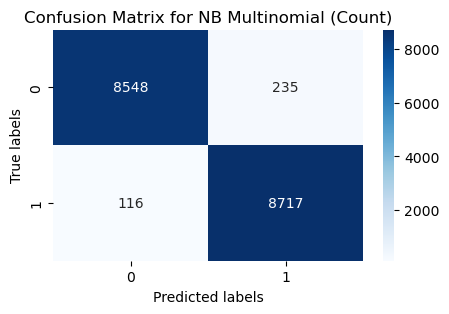

--- Prueba - NB Multinomial (Count) ---
Resultados para NB Multinomial (Count):
Accuracy: 0.9736603088101726
Precision: 0.9736498611299875
Recall: 0.9737084789979908
F1-Score: 0.9736590865076139
AUC Score: 0.9929143499033349




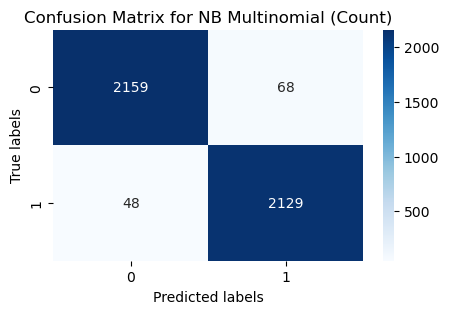

In [64]:
model_NB_1=validacion(MultinomialNB, best_params_NB_1, X_train_1, y_train, X_test_1, y_test, name="NB Multinomial (Count)")

--- Entrenamiento - NB Multinomial (TF-IDF) ({'alpha': 0.1})---
Resultados para NB Multinomial (TF-IDF):
Accuracy: 0.9913147138964578
Precision: 0.9913224903788896
Recall: 0.9913106158386544
F1-Score: 0.9913145564619521
AUC Score: 0.9994410367825753




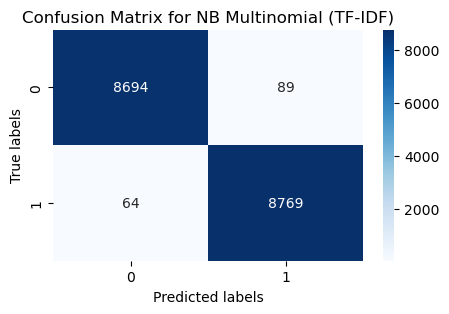

--- Prueba - NB Multinomial (TF-IDF) ---
Resultados para NB Multinomial (TF-IDF):
Accuracy: 0.9811534968210718
Precision: 0.9811368541239052
Recall: 0.9811794283998178
F1-Score: 0.9811520187359861
AUC Score: 0.9985450207180883




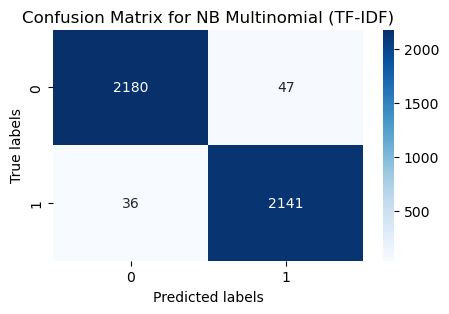

In [65]:
model_NB_2=validacion(MultinomialNB, best_params_NB_2, X_train_2, y_train, X_test_2, y_test, name="NB Multinomial (TF-IDF)")

--- Entrenamiento - NB Bernoulli (Count) ({'alpha': 0.001})---
Resultados para NB Bernoulli (Count):
Accuracy: 0.9514645776566758
Precision: 0.9551459519143513
Recall: 0.9513383491896693
F1-Score: 0.9513563311805098
AUC Score: 0.9979091260597948




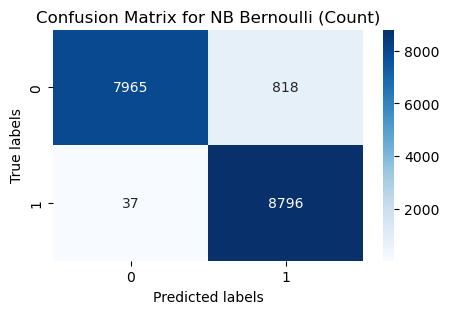

--- Prueba - NB Bernoulli (Count) ---
Resultados para NB Bernoulli (Count):
Accuracy: 0.9443687556766576
Precision: 0.9470144687455695
Recall: 0.9448282540723022
F1-Score: 0.9443194892366649
AUC Score: 0.9945635258104124




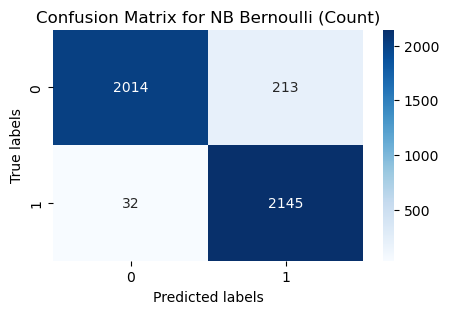

In [66]:
model_NB_0=validacion(BernoulliNB, best_params_NB_0, X_train_0, y_train, X_test_0, y_test, name="NB Bernoulli (Count)")

#### **SVM**

--- Entrenamiento - SVC (Count) ({'kernel': 'linear', 'gamma': 1, 'C': 1, 'probability': True})---
Resultados para SVC (Count):
Accuracy: 0.9995458673932789
Precision: 0.9995462111531515
Recall: 0.9995455414876977
F1-Score: 0.9995458634361649
AUC Score: 0.9999995424092467




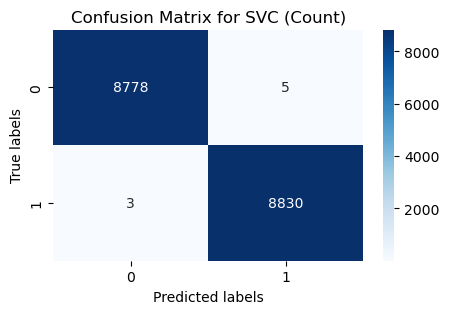

--- Prueba - SVC (Count) ---
Resultados para SVC (Count):
Accuracy: 0.9800181653042689
Precision: 0.980115969039447
Recall: 0.9801341905899101
F1-Score: 0.9800181488203267
AUC Score: 0.9960368625003326




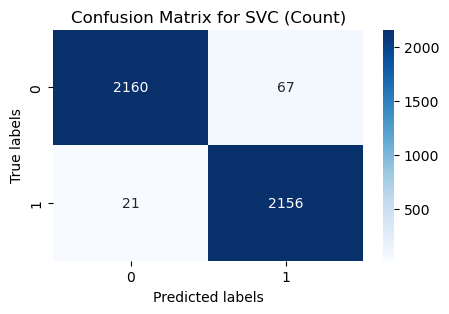

In [68]:
model_SVC_1=validacion(SVC, best_params_SVC_1, X_train_1, y_train, X_test_1, y_test, name="SVC (Count)")

--- Entrenamiento - SVC (TF-IDF) ({'kernel': 'rbf', 'gamma': 1, 'C': 10, 'probability': True})---
Resultados para SVC (TF-IDF):
Accuracy: 0.9998864668483197
Precision: 0.9998868138087154
Recall: 0.9998861436866675
F1-Score: 0.9998864658590412
AUC Score: 0.9999896300912402




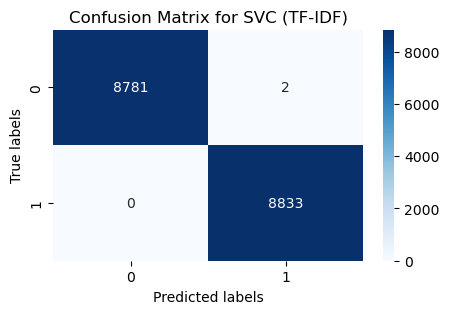

--- Prueba - SVC (TF-IDF) ---
Resultados para SVC (TF-IDF):
Accuracy: 0.992960944595822
Precision: 0.9929534354168041
Recall: 0.9929677720232689
F1-Score: 0.9929601427978652
AUC Score: 0.9993902865385127




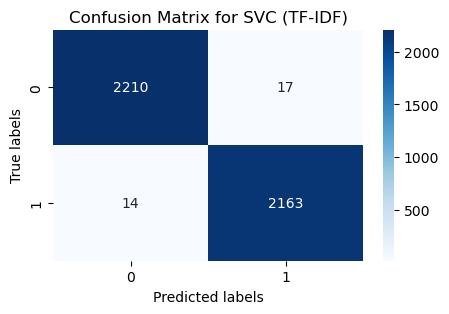

In [69]:
model_SVC_2=validacion(SVC, best_params_SVC_2, X_train_2, y_train, X_test_2, y_test, name="SVC (TF-IDF)")

--- Entrenamiento - LinearSVC (Count) ({'C': 0.1, 'max_iter': 1000})---
Resultados para LinearSVC (Count):
Accuracy: 0.9992052679382379
Precision: 0.9992056084975877
Recall: 0.9992049392887279
F1-Score: 0.9992052610132887
AUC Score: 0.9999949922814751




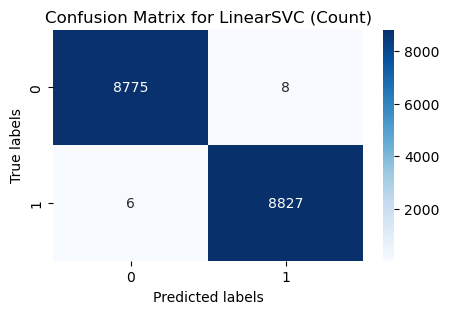

--- Prueba - LinearSVC (Count) ---
Resultados para LinearSVC (Count):
Accuracy: 0.9863760217983651
Precision: 0.9863989828316753
Recall: 0.9864567706761652
F1-Score: 0.9863757942039584
AUC Score: 0.9977298692973176




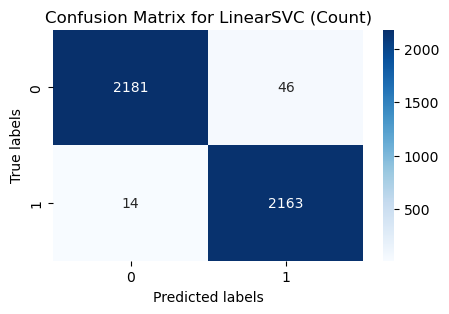

In [70]:
model_LinearSVC_1=validacion(LinearSVC, best_params_LinearSVC_1, X_train_1, y_train, X_test_1, y_test, name="LinearSVC (Count)")

--- Entrenamiento - LinearSVC (TF-IDF) ({'C': 1, 'max_iter': 1000})---
Resultados para LinearSVC (TF-IDF):
Accuracy: 0.9993188010899182
Precision: 0.9993182558440032
Recall: 0.9993194400960791
F1-Score: 0.9993187964450012
AUC Score: 0.9998417187139628




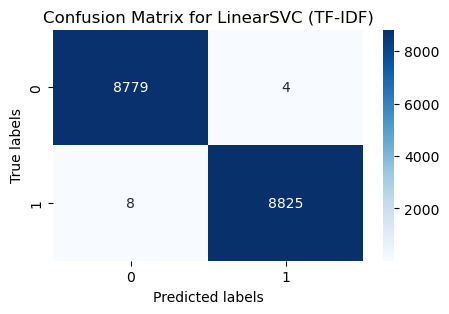

--- Prueba - LinearSVC (TF-IDF) ---
Resultados para LinearSVC (TF-IDF):
Accuracy: 0.9904632152588556
Precision: 0.990465894366094
Recall: 0.9905290213088254
F1-Score: 0.9904629320265805
AUC Score: 0.9993428460459072




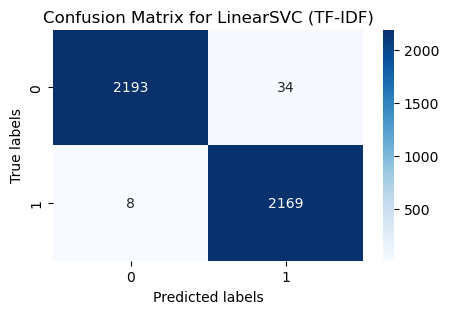

In [71]:
model_LinearSVC_2=validacion(LinearSVC, best_params_LinearSVC_2, X_train_2, y_train, X_test_2, y_test, name="LinearSVC (TF-IDF)")

--- Entrenamiento - SGDClassifier (Count) ({'alpha': 0.001, 'loss': 'hinge', 'penalty': 'l2'})---
Resultados para SGDClassifier (Count):
Accuracy: 0.9960263396911898
Precision: 0.9960403027474214
Recall: 0.9960205072325183
F1-Score: 0.9960262449839045
AUC Score: 0.9998415704803385




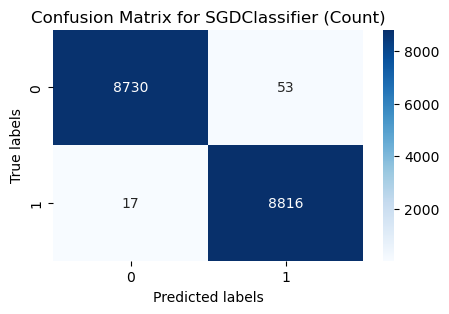

--- Prueba - SGDClassifier (Count) ---
Resultados para SGDClassifier (Count):
Accuracy: 0.9863760217983651
Precision: 0.9863914193655763
Recall: 0.986451614100882
F1-Score: 0.986375740816515
AUC Score: 0.9975278346777211




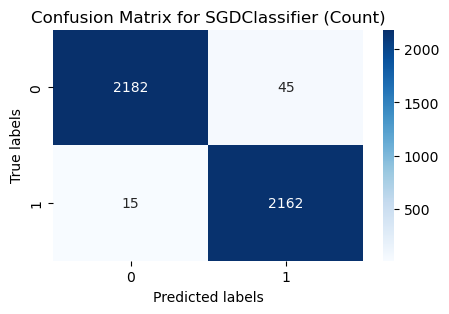

In [72]:
model_SGDClassifier_1=validacion(SGDClassifier, best_params_SGDClassifier_1, X_train_1, y_train, X_test_1, y_test, name="SGDClassifier (Count)")

--- Entrenamiento - SGDClassifier (TF-IDF) ({'alpha': 0.0001, 'loss': 'modified_huber', 'penalty': 'l2'})---
Resultados para SGDClassifier (TF-IDF):
Accuracy: 0.9990917347865577
Precision: 0.9990914321264532
Recall: 0.9990920497164233
F1-Score: 0.9990917280430823
AUC Score: 0.9997081279937795




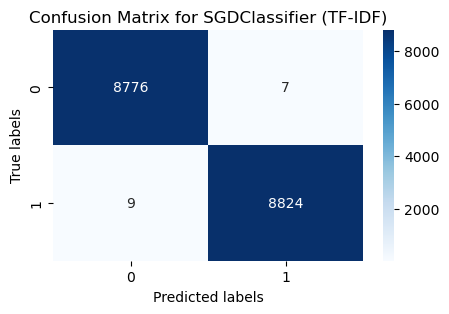

--- Prueba - SGDClassifier (TF-IDF) ---
Resultados para SGDClassifier (TF-IDF):
Accuracy: 0.9904632152588556
Precision: 0.9904607384544186
Recall: 0.9905238647335421
F1-Score: 0.9904628828525968
AUC Score: 0.9992432210114355




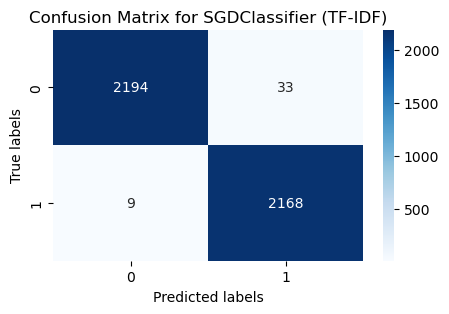

In [73]:
model_SGDClassifier_2=validacion(SGDClassifier, best_params_SGDClassifier_2, X_train_2, y_train, X_test_2, y_test, name="SGDClassifier (TF-IDF)")

### Top palabras predictoras de Spam/Ham

Por último, para el mejor modelo entrenado (SVC con vectorización tf-idf), podemos mostrar un ranking de las palabras más determinantes a la hora de clasificar entre Spam y Ham. Esto significa que si aparece dicha palabra en un correo, el modelo lo clasificará muy seguramente con una clase u otra. Para mostrar este ranking, extraemos los pesos del modelo y mostramos su característica término asociado, por orden.

In [76]:
import numpy as np
#Extraemos los pesos, esto nos devuelve una matriz dispersa
weights = model_SVC_1.coef_[0]
if isinstance(weights, np.ndarray):
    dense_weights = weights
else:
    dense_weights = weights.toarray()[0]  #Convertimos la matriz dispersa en una matriz densa

#Tomamos los índices de los 15 términos con mayor peso para el caso Spam (los más altos positivos)
spam_indices = dense_weights.argsort()[-15:][::-1] #La función argsort ordena en orden ascendente por defecto, por eso lo invertimos

# Tomamos los índices de los 15 términos con mayor peso para el caso Spam (los más altos pero negativos)
ham_indices = dense_weights.argsort()[:15]  #La función argsort ordena en orden ascendente por defecto

#Cogemos los términos en el vectorizer
feature_names = vectorizer_1.get_feature_names_out()

#Dado el índice, mostramos su correspondiente término
print('Top predictors of Spam:')
for index in spam_indices:
    print(f'{feature_names[index]:10s} ({dense_weights[index]:8f})')

print('\nTop predictors of Ham:')
for index in ham_indices:
    print(f'{feature_names[index]:10s} ({dense_weights[index]:8f})')

Top predictors of Spam:
click      (0.931283)
instructions (0.795358)
wish       (0.745940)
xm         (0.720586)
sightings  (0.681662)
arabia     (0.652055)
saudi      (0.627169)
knew       (0.606327)
dating     (0.605892)
tel        (0.605512)
cards      (0.574324)
refuse     (0.552601)
carry      (0.552600)
gpo        (0.552598)
merchant   (0.552597)

Top predictors of Ham:
enron      (-1.291580)
date       (-1.111402)
revised    (-1.000114)
avi        (-1.000000)
hart       (-0.997911)
tw         (-0.913973)
vince      (-0.887259)
california (-0.850464)
thanks     (-0.825936)
gif        (-0.818813)
wrote      (-0.810769)
deserved   (-0.786866)
louise     (-0.786121)
serv       (-0.771182)
attached   (-0.761796)


## **5. Otras representaciones: synsets**

### **Detección de hiperónimos en synsets**
Vamos a crear un dataset aparte, donde los términos sean obtenidos a partir de **synsets** de los términos originales. Usaremos los synsets del paquete WordNet de la librería NLTK.
De esta forma, estamos intentando agrupar términos que tienen relación. Por ejemplo, podemos observar que las palabras "dollar" y "euro" pertenecen a la misma categoría: "monetary_unit". De hecho no tiene sentido tratarlos como palabras completamente distintas, como lo harían nuestros algoritmos de clasificación sin este procesamiento.

A este nuevo dataset le aplicaremos todo el preprocesamiento anterior, y compararemos los resultados con el dataset si

In [159]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def obtener_primer_hiperonimo(palabra):
    # Lematizamos la palabra antes de obtener los synsets
    palabra_lematizada = lemmatizer.lemmatize(palabra)
    
    # Obtenemos todos los synsets de la palabra lematizada
    synsets = wn.synsets(palabra_lematizada)

    #Verificar si hay al menos un synset
    if synsets:
        #Seleccionamos el primer synset
        primer_synset = synsets[0]

        #Obtenemos los hiperónimos del primer synset
        hiperonimos = primer_synset.hypernyms()

        # Verificar si el synset tiene hiperónimos
        if hiperonimos:
            # Seleccionar el primer hiperónimo y obtener el primer lema
            primer_hiperonimo = hiperonimos[0].lemmas()[0].name()
            return primer_hiperonimo
        else:
            return palabra #No hay hiperónimos así que dejamos la palabra inicial
    else:
        return palabra #No hay synsets así que dejamos la palabra inicial

# Ejemplo de uso de la función
palabra = "dollar"
hiperonimo = obtener_primer_hiperonimo(palabra)
print(f"El primer hiperónimo de '{palabra}' es: {hiperonimo}")

palabra = "euro"
hiperonimo = obtener_primer_hiperonimo(palabra)
print(f"El primer hiperónimo de '{palabra}' es: {hiperonimo}")

El primer hiperónimo de 'dollar' es: monetary_unit
El primer hiperónimo de 'euro' es: monetary_unit


In [80]:
def reemplazar_con_hiperonimos(frase):
    palabras = frase.split()
    palabras_con_hiperonimos = [obtener_primer_hiperonimo(palabra) for palabra in palabras]
    frase_transformada = ' '.join(palabras_con_hiperonimos)
    return frase_transformada

**Ejemplos**

In [161]:
reemplazar_con_hiperonimos("fight risk cancer URL slim guaranteed lose lbs days URL")

'military_action danger malignant_tumor address change_state pledge lose avoirdupois_unit time_unit address'

In [163]:
reemplazar_con_hiperonimos("make week using home computer free software computer start making huge amounts cash working")

'kind time_period mistreatment residence machine people code machine beginning production huge assets currency excavation'

In [165]:
reemplazar_con_hiperonimos("intern compensation sally summer analysts benefit recent compensation changes monthly salary summer let know questions")

'doctor recompense remark season expert payment recent recompense happening series regular_payment season let knowing questioning'

**Aplico la función al dataset**

In [81]:
data_synsets=data_clean

In [82]:
data_synsets['Body'] = data_synsets['Body'].apply(reemplazar_con_hiperonimos)

In [83]:
data_synsets.head()

,Body,Label
0,capital promo workman cwtd urgent capitalist c...,1
1,enumerate commissioned_military_officer activi...,1
2,important message thu jun important message th...,1
3,utf being utf causal_agent utf internal utf ti...,1
4,bidstogo point property greeting reclusiveness...,1


In [84]:
data_synsets=seleccion_caracteristicas(data_synsets)

Counter({'message': 52876, 'activity': 45629, 'communication': 34918, 'Gregorian_calendar_month': 23715, 'person': 21535, 'kind': 20738, 'body': 20686, 'time_period': 20650, 'act': 20173, 'metallic_element': 20063, 'address': 19771, 'enron': 17925, 'property': 17816, 'collection': 17647, 'information': 17428, 'code': 16484, 'computer_network': 16051, 'happening': 14983, 'weekday': 14784, 'people': 14144, 'writing': 13449, 'idea': 13340, 'document': 13268, 'written_record': 13146, 'new': 13109, 'statement': 12932, 'com': 12660, 'point': 12576, 'case': 12321, 'electronic_communication': 12177, 'database': 11900, 'meeting': 11788, 'quality': 11735, 'examination': 11727, 'change': 11677, 'time_unit': 11643, 'content': 11634, 'large_integer': 11370, 'electrotherapy': 11065, 'work': 11042, 'get': 10898, 'institution': 10803, 'tract': 10672, 'abstraction': 10557, 'move': 10501, 'science': 10321, 'protocol': 10143, 'investigation': 9885, 'command': 9592, 'group': 9399, 'assets': 9254, 'word': 

In [85]:
X_train_synsets, X_test_synsets, y_train_synsets, y_test_synsets= division_datos(data_synsets)

In [86]:
X_train_synsets, X_test_synsets, vectorizer_synsets= vectorizacion(X_train_synsets, X_test_synsets, "tfidf")

**Realizamos los puntos 3 y 4 igual que antes, para CountVectorizer**

In [88]:
best_params_NB_synsets=busqueda_hiperparametros(param_grid_NB, MultinomialNB, X_train_synsets, y_train_synsets, "NB Multinomial Synsets")

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.2; total time=   0.0s
[CV] END ........................................

In [89]:
print(f"\nHiperparámetros del mejor modelo para Naive Bayes Multinomial: {best_params_NB_synsets}")
#print(f"\nHiperparámetros del mejor modelo para SVM: {best_params_SVM_synsets}")


Hiperparámetros del mejor modelo para Naive Bayes Multinomial: {'alpha': 0.1}


--- Entrenamiento - NB Multinomial Synsets ({'alpha': 0.1})---
Resultados para NB Multinomial Synsets:
Accuracy: 0.9835657370517928
Precision: 0.9836537511549722
Recall: 0.9811899158048196
F1-Score: 0.9823961838121213
AUC Score: 0.9988488131518202




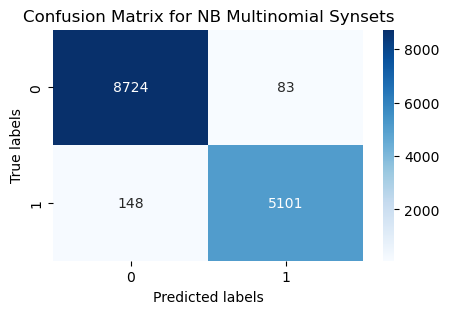

--- Prueba - NB Multinomial Synsets ---
Resultados para NB Multinomial Synsets:
Accuracy: 0.9678429140580534
Precision: 0.9672570217586625
Recall: 0.9638522533415186
F1-Score: 0.9655040395810224
AUC Score: 0.9961947735786405




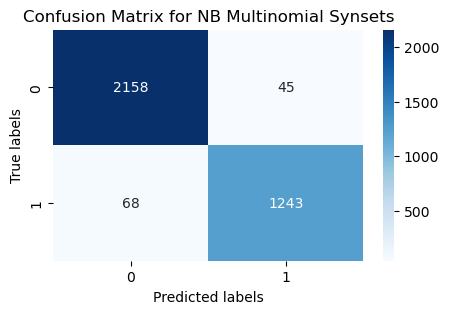

In [90]:
model_NB_synsets=validacion(MultinomialNB, best_params_NB_synsets, X_train_synsets, y_train_synsets, X_test_synsets, y_test_synsets, name="NB Multinomial Synsets")

## **6. Comparaciones**
Realizamos comparaciones entre los resultados obtenidos por los 5 clasificadores (NB Multinomial, NB Bernoulli, SVC, LinearSVC, SGDClassifier), con los dos tipos de vectorizaciones (CountVectorizer y TDIFVectorizer).

Mostraremos una tabla para entrenamiento y otra para test. Cada fila de la tabla representará las métricas para cada modelo.

In [93]:
def plot_roc_curve(y_test, y_scores, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC - ' + model_name)
    plt.legend(loc="lower right")
    plt.show()

In [94]:
#Función que devuelve todas las métricas para entrenamiento y para prueba
def validacion_train_test(algoritmo_clasificacion, parametros, X_train, y_train, X_test, y_test, name):
    print(f"\nValidando {name}")
    if algoritmo_clasificacion == SVC:
        parametros = parametros.copy()  # Copiar para no modificar el original externamente
        parametros['probability'] = True  # Habilitar la estimación de probabilidades
        
    #Reentrenamos el mejor modelo pero ahora sí con todo el conjunto de entrenamiento
    model = algoritmo_clasificacion(**parametros)
    model.fit(X_train, y_train)

    # Calibración del modelo para poder usar predict_proba en LinearSVC y en SGDClassifier
    if algoritmo_clasificacion == LinearSVC or algoritmo_clasificacion == SGDClassifier:
        model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
        model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    #y_test_scores = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
    
    train_metrics = {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred, average='macro'),
        'Recall': recall_score(y_train, y_train_pred, average='macro'),
        'F1-Score': f1_score(y_train, y_train_pred, average='macro'),
        'AUC': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    }
    test_metrics = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, average='macro'),
        'Recall': recall_score(y_test, y_test_pred, average='macro'),
        'F1-Score': f1_score(y_test, y_test_pred, average='macro'),
        'AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),
        #'y_scores': y_test_scores
    }

    # Plot ROC curve
    #plot_roc_curve(y_test, y_test_scores, name)
    
    return train_metrics, test_metrics


#### **Tabla comparativa con las métricas para cada modelo**

In [96]:
columns = ['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
df_metrics_train = pd.DataFrame(columns=columns)
df_metrics_test = pd.DataFrame(columns=columns)

#Validar y recopilar métricas para NB Multinomial Count
train_metrics_NB_1, test_metrics_NB_1 = validacion_train_test(MultinomialNB, best_params_NB_1, X_train_1, y_train, X_test_1, y_test, "NB Multinomial (Count)")
df_metrics_train = pd.concat([df_metrics_train, pd.DataFrame([['NB Multinomial (Count)'] + list(train_metrics_NB_1.values())], columns=columns)], ignore_index=True)
df_metrics_test = pd.concat([df_metrics_test, pd.DataFrame([['NB Multinomial (Count)'] + list(test_metrics_NB_1.values())], columns=columns)], ignore_index=True)

#Validar y recopilar métricas para NB Multinomial tf-idf
train_metrics_NB_2, test_metrics_NB_2 = validacion_train_test(MultinomialNB, best_params_NB_2, X_train_2, y_train, X_test_2, y_test, "NB Multinomial (TF-IDF)")
df_metrics_train = pd.concat([df_metrics_train, pd.DataFrame([['NB Multinomial (TF-IDF)'] + list(train_metrics_NB_2.values())], columns=columns)], ignore_index=True)
df_metrics_test = pd.concat([df_metrics_test, pd.DataFrame([['NB Multinomial (TF-IDF)'] + list(test_metrics_NB_2.values())], columns=columns)], ignore_index=True)

#Validar y recopilar métricas para NB de Bernoulli Count
train_metrics_NB_0, test_metrics_NB_0 = validacion_train_test(BernoulliNB, best_params_NB_0, X_train_0, y_train, X_test_0, y_test, "NB Bernoulli (Count)")
df_metrics_train = pd.concat([df_metrics_train, pd.DataFrame([['NB Bernoulli (Count)'] + list(train_metrics_NB_0.values())], columns=columns)], ignore_index=True)
df_metrics_test = pd.concat([df_metrics_test, pd.DataFrame([['NB Bernoulli (Count)'] + list(test_metrics_NB_0.values())], columns=columns)], ignore_index=True)

#Validar y recopilar métricas para SVC Count
train_metrics_SVC_1, test_metrics_SVC_1 = validacion_train_test(SVC, best_params_SVC_1, X_train_1, y_train, X_test_1, y_test, "SVC (Count)")
df_metrics_train = pd.concat([df_metrics_train, pd.DataFrame([['SVC (Count)'] + list(train_metrics_SVC_1.values())], columns=columns)], ignore_index=True)
df_metrics_test = pd.concat([df_metrics_test, pd.DataFrame([['SVC (Count)'] + list(test_metrics_SVC_1.values())], columns=columns)], ignore_index=True)

#Validar y recopilar métricas para SVC tf-idf
train_metrics_SVC_2, test_metrics_SVC_2 = validacion_train_test(SVC, best_params_SVC_2, X_train_2, y_train, X_test_2, y_test, "SVC (TF-IDF)")
df_metrics_train = pd.concat([df_metrics_train, pd.DataFrame([['SVC (TF-IDF)'] + list(train_metrics_SVC_2.values())], columns=columns)], ignore_index=True)
df_metrics_test = pd.concat([df_metrics_test, pd.DataFrame([['SVC (TF-IDF)'] + list(test_metrics_SVC_2.values())], columns=columns)], ignore_index=True)

#Validar y recopilar métricas para LinearSVC Count
train_metrics_LinearSVC_1, test_metrics_LinearSVC_1 = validacion_train_test(LinearSVC, best_params_LinearSVC_1, X_train_1, y_train, X_test_1, y_test, "LinearSVC (Count)")
df_metrics_train = pd.concat([df_metrics_train, pd.DataFrame([['LinearSVC (Count)'] + list(train_metrics_LinearSVC_1.values())], columns=columns)], ignore_index=True)
df_metrics_test = pd.concat([df_metrics_test, pd.DataFrame([['LinearSVC (Count)'] + list(test_metrics_LinearSVC_1.values())], columns=columns)], ignore_index=True)

#Validar y recopilar métricas para LinearSVC Count
train_metrics_LinearSVC_2, test_metrics_LinearSVC_2 = validacion_train_test(LinearSVC, best_params_LinearSVC_2, X_train_2, y_train, X_test_2, y_test, "LinearSVC (TF-IDF)")
df_metrics_train = pd.concat([df_metrics_train, pd.DataFrame([['LinearSVC (TF-IDF)'] + list(train_metrics_LinearSVC_2.values())], columns=columns)], ignore_index=True)
df_metrics_test = pd.concat([df_metrics_test, pd.DataFrame([['LinearSVC (TF-IDF)'] + list(test_metrics_LinearSVC_2.values())], columns=columns)], ignore_index=True)

#Validar y recopilar métricas para SGDClassifier Count
train_metrics_SGDClassifier_1, test_metrics_SGDClassifier_1 = validacion_train_test(SGDClassifier, best_params_SGDClassifier_1, X_train_1, y_train, X_test_1, y_test, "SGDClassifier (Count)")
df_metrics_train = pd.concat([df_metrics_train, pd.DataFrame([['SGDClassifier (Count)'] + list(train_metrics_SGDClassifier_1.values())], columns=columns)], ignore_index=True)
df_metrics_test = pd.concat([df_metrics_test, pd.DataFrame([['SGDClassifier (Count)'] + list(test_metrics_SGDClassifier_1.values())], columns=columns)], ignore_index=True)

#Validar y recopilar métricas para SGDClassifier tf-idf
train_metrics_SGDClassifier_2, test_metrics_SGDClassifier_2 = validacion_train_test(SGDClassifier, best_params_SGDClassifier_2, X_train_2, y_train, X_test_2, y_test, "SGDClassifier (TF-IDF)")
df_metrics_train = pd.concat([df_metrics_train, pd.DataFrame([['SGDClassifier (TF-IDF)'] + list(train_metrics_SGDClassifier_2.values())], columns=columns)], ignore_index=True)
df_metrics_test = pd.concat([df_metrics_test, pd.DataFrame([['SGDClassifier (TF-IDF)'] + list(test_metrics_SGDClassifier_2.values())], columns=columns)], ignore_index=True)


# Imprimir los DataFrames finales con todas las métricas
print("Training Metrics:")
print(df_metrics_train)
print("\nTesting Metrics:")
print(df_metrics_test)

Training Metrics:
                Classifier  Accuracy  Precision    Recall  F1-Score       AUC
0   NB Multinomial (Count)  0.980075   0.980180  0.980056  0.980073  0.996390
1  NB Multinomial (TF-IDF)  0.991315   0.991322  0.991311  0.991315  0.999441
2     NB Bernoulli (Count)  0.951465   0.955146  0.951338  0.951356  0.997909
3              SVC (Count)  0.999546   0.999546  0.999546  0.999546  1.000000
4             SVC (TF-IDF)  0.999886   0.999887  0.999886  0.999886  0.999990
5        LinearSVC (Count)  0.999205   0.999206  0.999205  0.999205  0.999995
6       LinearSVC (TF-IDF)  0.999319   0.999318  0.999319  0.999319  0.999842
7    SGDClassifier (Count)  0.996821   0.996829  0.996817  0.996821  0.999848
8   SGDClassifier (TF-IDF)  0.999092   0.999091  0.999092  0.999092  0.999772

Testing Metrics:
                Classifier  Accuracy  Precision    Recall  F1-Score       AUC
0   NB Multinomial (Count)  0.973660   0.973650  0.973708  0.973659  0.992914
1  NB Multinomial (TF-IDF)  

#### **Gráfico de barras**

In [147]:
data_train = {
    'Classifier': ['MultinomialNB', 'BernoulliNB', 'SVC', 'LinearSVC', 'SGDClassifier'],
    'countVectorizer': [train_metrics_NB_1['Accuracy'], train_metrics_NB_0['Accuracy'], train_metrics_SVC_1['Accuracy'], train_metrics_LinearSVC_1['Accuracy'], train_metrics_SGDClassifier_1['Accuracy']],
    'tf-idfVectorizer': [train_metrics_NB_2['Accuracy'], 0, train_metrics_SVC_2['Accuracy'], train_metrics_LinearSVC_2['Accuracy'], train_metrics_SGDClassifier_2['Accuracy']]
}

df_train = pd.DataFrame(data_train)

data_test = {
    'Classifier': ['MultinomialNB', 'BernoulliNB', 'SVC', 'LinearSVC', 'SGDClassifier'],
    'countVectorizer': [test_metrics_NB_1['Accuracy'], test_metrics_NB_0['Accuracy'], test_metrics_SVC_1['Accuracy'], test_metrics_LinearSVC_1['Accuracy'], test_metrics_SGDClassifier_1['Accuracy']],
    'tf-idfVectorizer': [test_metrics_NB_2['Accuracy'], 0, test_metrics_SVC_2['Accuracy'], test_metrics_LinearSVC_2['Accuracy'], test_metrics_SGDClassifier_2['Accuracy']]
}

df_test = pd.DataFrame(data_test)


In [143]:
def grafico_barras_accuracy(df, fase):
    # Configurando las posiciones y el ancho de las barras
    pos = np.arange(len(df['Classifier']))
    bar_width = 0.35
    
    # Creando el gráfico
    fig, ax = plt.subplots(figsize=(10, 5))
    # Seleccionando colores personalizados para cada grupo de barras
    color_tf_idf = '#15DBDB'  # Azul claro
    color_count = '#0B6399'  # Azul
    bars1 = ax.bar(pos - bar_width/2, df['countVectorizer'], bar_width, label='Count Vectorizer', color=color_count)
    bars2 = ax.bar(pos + bar_width/2, df['tf-idfVectorizer'], bar_width, label='TF-IDF Vectorizer', color=color_tf_idf)
    
    # Añadiendo títulos y etiquetas
    ax.set_xlabel('Clasificadores')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy por clasificador y tipo de vectorización ({fase})')
    ax.set_xticks(pos)
    ax.set_xticklabels(df['Classifier'], rotation=45)  # Rotación ajustada aquí
    
    # Ajustando la leyenda
    ax.legend(loc='upper center', bbox_to_anchor=(0.75, 0.15), fancybox=True, shadow=True, ncol=2)
    
    # Añadiendo etiquetas de texto para mostrar el porcentaje
    for bars in (bars1, bars2):
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, format(yval, ".4f"), ha='center', va='bottom', fontweight='bold')
    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

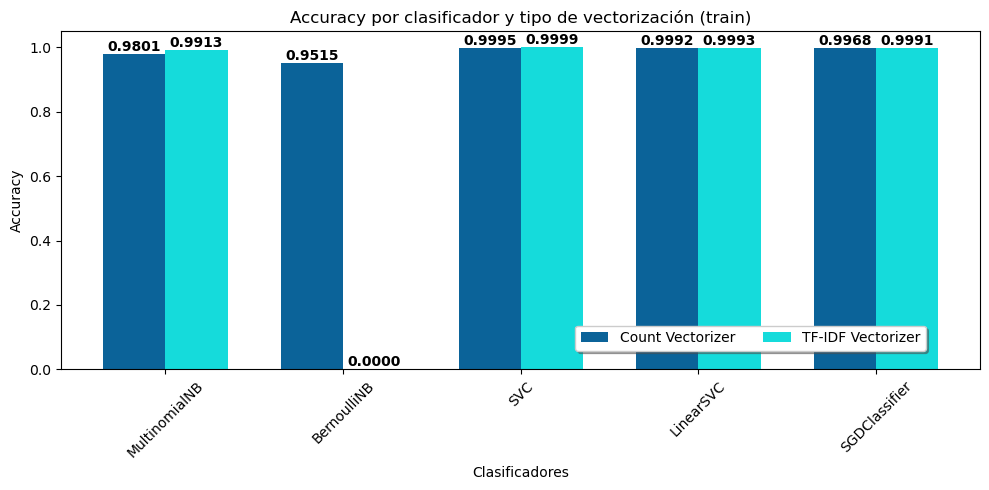

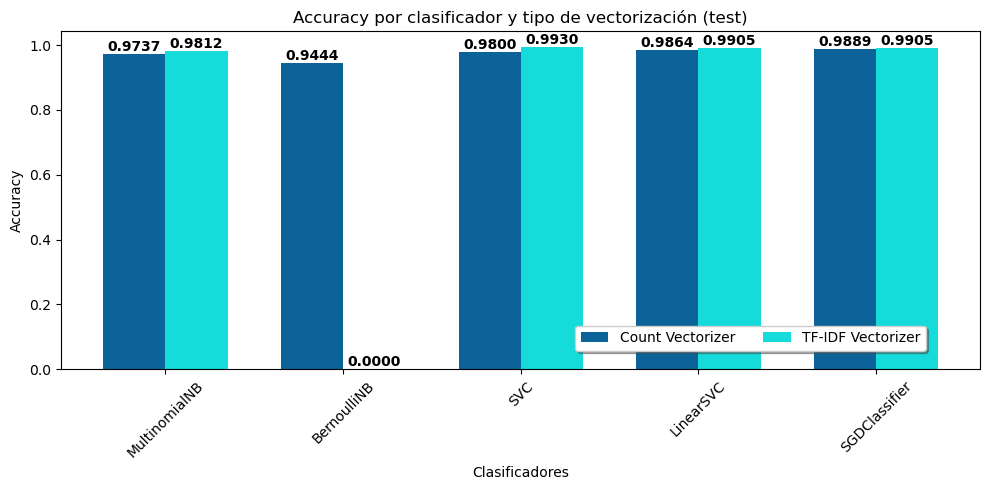

In [149]:
grafico_barras_accuracy(df_train, "train")
grafico_barras_accuracy(df_test, "test")

#### **Curva ROC**
También vamos a mostrar la gráfica de la curva ROC para todos los modelos entrenados

In [1]:
#Función para representar en una gráfica distintas curvas ROC, incluyendo la de un clasificador random
def plot_combined_roc_curves(y_tests, y_score_lists, model_names, title="Combined ROC Curves"):
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange', 'purple', 'brown']
    
    for i, y_scores in enumerate(y_score_lists):
        fpr, tpr, _ = roc_curve(y_tests[i], y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
                 label='ROC curve of {0} (area = {1:0.3f})'.format(model_names[i], roc_auc))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [101]:
#Función que devuelve las métricas necesarias para representar la curva ROC
def validacion_curvaROC(algoritmo_clasificacion, parametros, X_train, y_train, X_test, y_test, name):
    print(f"\nValidando {name}")
    if algoritmo_clasificacion == SVC:
        parametros = parametros.copy()  # Copiar para no modificar el original externamente
        parametros['probability'] = True  # Habilitar la estimación de probabilidades
        
    #Reentrenamos el mejor modelo pero ahora sí con todo el conjunto de entrenamiento
    model = algoritmo_clasificacion(**parametros)
    model.fit(X_train, y_train)

    # Calibración del modelo para poder usar predict_proba en LinearSVC y en SGDClassifier
    if algoritmo_clasificacion == LinearSVC or algoritmo_clasificacion == SGDClassifier:
        model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
        model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_scores = model.predict_proba(X_test)[:, 1]  # Probabilidades para la clase positiva
    
    return y_test_scores


Validando NB Multinomial (Count)

Validando NB Multinomial (TF-IDF)

Validando NB Bernoulli (Count)

Validando SVC (Count)

Validando SVC (TF-IDF)

Validando LinearSVC (Count)

Validando LinearSVC (TF-IDF)

Validando SGDClassifier (Count)

Validando SGDClassifier (TF-IDF)


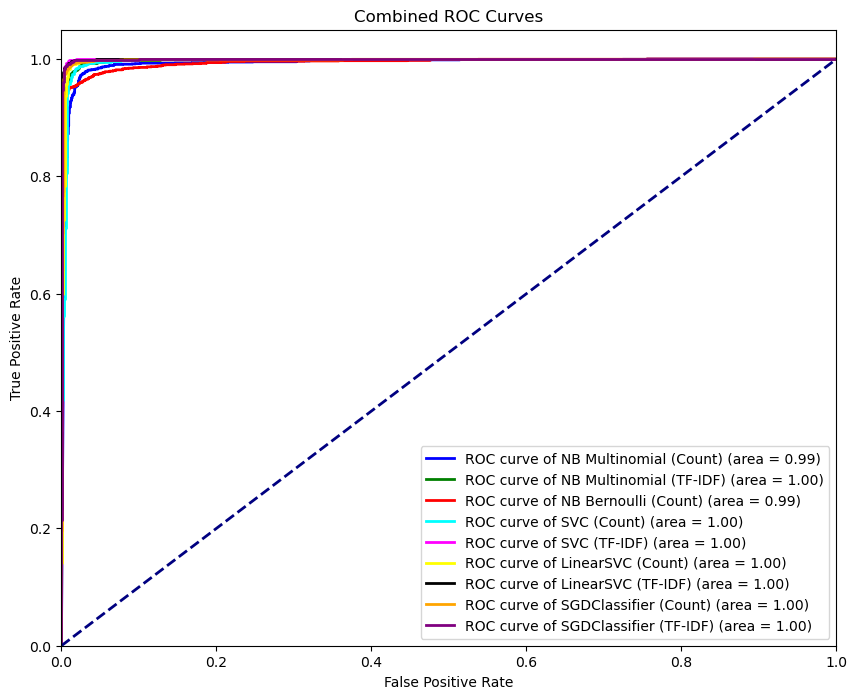

In [171]:
model_list = [(MultinomialNB, best_params_NB_1, "NB Multinomial (Count)", "count"),
              (MultinomialNB, best_params_NB_2, "NB Multinomial (TF-IDF)", "tfidf"),
              (BernoulliNB, best_params_NB_0, "NB Bernoulli (Count)", ""),
              (SVC, best_params_SVC_1, "SVC (Count)", "count"),
              (SVC, best_params_SVC_2, "SVC (TF-IDF)", "tfidf"),
              (LinearSVC, best_params_LinearSVC_1, "LinearSVC (Count)", "count"),
              (LinearSVC, best_params_LinearSVC_2, "LinearSVC (TF-IDF)", "tfidf"),
              (SGDClassifier, best_params_SGDClassifier_1, "SGDClassifier (Count)", "count"),
              (SGDClassifier, best_params_SGDClassifier_2, "SGDClassifier (TF-IDF)", "tfidf")
             ]

y_tests = []
y_scores = []
model_names = []

for model, params, name, type in model_list:
    if type=="count":
        y_test_scores = validacion_curvaROC(model, params, X_train_1, y_train, X_test_1, y_test, name)
    elif type== "tfidf":
        y_test_scores = validacion_curvaROC(model, params, X_train_2, y_train, X_test_2, y_test, name)
    else:
        y_test_scores = validacion_curvaROC(model, params, X_train_0, y_train, X_test_0, y_test, name)
    y_tests.append(y_test)
    y_scores.append(y_test_scores) 
    model_names.append(name)

plot_combined_roc_curves(y_tests, y_scores, model_names)